In [96]:
from gas_turbine_cycle.gases import Air, KeroseneCombustionProducts, NaturalGasCombustionProducts
import pandas as pd
import matplotlib.pyplot as plt
import config
import os
import pickle
from gas_turbine_cycle.core.turbine_lib import Inlet, Outlet, Turbine, Compressor, CombustionChamber, Sink, Source, Load

def kelvin(temp_cels):
    return temp_cels + 273

def celsius(temp_kelv):
    return temp_kelv - 273


# Загрузка результатов расчета цикла

In [97]:
with open(os.path.join(config.output_dirname, config.cycle_results), 'rb') as f:
    units = pickle.load(f)[0]
    
comp_turbine: Turbine = units['comp_turbine']
power_turbine: Turbine = units['power_turbine']
inlet: Inlet = units['inlet']
outlet: Outlet = units['outlet']
comb_chamber: CombustionChamber = units['comb_chamber']
sink: Sink = units['sink']
source: Source = units['source']
comp: Compressor = units['compressor']
turb_load: Load = units['turb_load']

N_e_specific = turb_load.consumable_labour
G_air = turb_load.power / N_e_specific
G_gas = comp_turbine.g_in * G_air
C_e = 3600 * comb_chamber.g_fuel_prime * comb_chamber.g_in / N_e_specific
G_fuel = comb_chamber.g_fuel_prime * comb_chamber.g_in * G_air
eta_e = 3600 / (C_e * comb_chamber.Q_n)

# Расчет начальной температуры газа аналогов

In [98]:
def get_gas_temp(T0=300, T_out = kelvin(400), pi_c=10, eta_c=0.84, eta_m=0.98, N=16, 
                 G_gas=50, G_fuel=0.9, eta_r=0.99, precision=0.001):
    """
    Возвращает значение температуры газа перед турбиной
    
    T0: температура на входе
    T_out: температура выхлопных газов
    pi_c: степень повышения давления в компрессоре
    eta_c: КПД процесса сжатия
    eta_m: механический КПД
    N: мощность на валу силовой турбины в МВт
    G_gas: расход газа
    G_fuel: расход топлива
    eta_r: КПД редуктора
    precision: точность
    """
    air = Air()
    air.T1 = T0
    gas = NaturalGasCombustionProducts()
    gas.T1 = T_out
    gas.T2 = 800
    gas.alpha = 2.5
    k_res = 1
    while k_res >= 0.001:
#       работа компрессора
        L_c = air.c_p_av_int * T0 * (pi_c ** ((air.k_av_int - 1) / air.k_av_int) - 1) / eta_c
#       температура за компрессором
        T_c = T0 + L_c / air.c_p_av_int
        k_old = air.k_av_int
#       уточнение теплоемкости
        air.T2 = T_c
        k_res = abs(air.k_av_int - k_old) / air.k_av_int
    G_air = G_gas - G_fuel
#   работа расширения
    L_ext = (L_c * G_air + N *1e6 / eta_r) / (eta_m * G_gas)
    k_gas_res = 1
    while k_gas_res >= 0.001:
#       Температура перед турбиной
        T_gas = T_out + L_ext / gas.c_p_av_int
#       уточнение теплоемкости газа
        k_gas_old = gas.k_av_int
        gas.T2 = T_gas
        k_gas_res = abs(k_gas_old - gas.k_av_int) / gas.k_av_int
    return T_gas


In [99]:
class12MW = pd.DataFrame.from_dict({
    'Engine': ['ГТУ-12ПГ-2', 'SGT-400', 'Mars 100'],
    'N': [12.9, 13.5, 11.87],
    'eta_e': [34.1, 36.4, 34.4],
    'pi_c': [15.9, 16.8, 16.3],
    'T_out': [496, 555, 485],
    'G_gas_out': [45.9, 39.4, 42.6]
})
class16MW = pd.DataFrame.from_dict({
    'Engine': ['ГТЭ-16ПА', 'SGT-500', 'Titan 130', 'Т16'],
    'N': [16.8, 19.7, 16.96, 16.5],
    'eta_e': [36.6, 34.7, 36.6, 37.0],
    'pi_c': [19.9, 13, 17.1, 19.0],
    'T_out': [481, 369, 490, 490],
    'G_gas_out': [56.3, 97.9, 54.7, 54.3]
})
class25MW = pd.DataFrame.from_dict({
    'Engine': ['ГТЭ-25П', 'SGT-600', 'Titan 250', 'LM2500', 'Т25'],
    'N': [23.8, 25.63, 22.5, 23.9, 22.4],
    'eta_e': [38.0, 35.4, 40.3, 34.35, 40.0],
    'pi_c': [27.3, 14, 24, 18.7, 24],
    'T_out': [473, 543, 465, 517, 465],
    'G_gas_out': [76.7, 80.4, 68.2, 71.7, 68.24]
})

gas = NaturalGasCombustionProducts()

class12MW['G_fuel'] = class12MW['N']*1e6 / (0.01 * class12MW['eta_e'] * gas.Q_n)
class16MW['G_fuel'] = class16MW['N']*1e6 / (0.01 * class16MW['eta_e'] * gas.Q_n)
class25MW['G_fuel'] = class25MW['N']*1e6 / (0.01 * class25MW['eta_e'] * gas.Q_n)

# расчет температуры газа
class12MW['T_gas'] = [get_gas_temp(T0=300, T_out=kelvin(T_out), pi_c=pi_c, N=N, G_gas=G_gas, G_fuel=G_fuel) 
                      for T_out, pi_c, N, G_gas, G_fuel in 
                      zip(class12MW.T_out, class12MW.pi_c, class12MW.N, class12MW.G_gas_out, class12MW.G_fuel)]
class16MW['T_gas'] = [get_gas_temp(T0=300, T_out=kelvin(T_out), pi_c=pi_c, N=N, G_gas=G_gas, G_fuel=G_fuel) 
                      for T_out, pi_c, N, G_gas, G_fuel in
                      zip(class16MW.T_out, class16MW.pi_c, class16MW.N, class16MW.G_gas_out, class16MW.G_fuel)]
class25MW['T_gas'] = [get_gas_temp(T0=300, T_out=kelvin(T_out), pi_c=pi_c, N=N, G_gas=G_gas, G_fuel=G_fuel) 
                      for T_out, pi_c, N, G_gas, G_fuel in
                      zip(class25MW.T_out, class25MW.pi_c, class25MW.N, class25MW.G_gas_out, class25MW.G_fuel)]

class12MW['C_e'] = 3600 / (class12MW['eta_e'] * 0.01 * gas.Q_n) * 1e3
class16MW['C_e'] = 3600 / (class16MW['eta_e'] * 0.01 * gas.Q_n) * 1e3
class25MW['C_e'] = 3600 / (class25MW['eta_e'] * 0.01 * gas.Q_n) * 1e3

class16MW = class16MW.append({
    'Engine': 'Проект',
    'G_gas_out': round(power_turbine.g_out * G_air, 2),
    'N': round(turb_load.power / 1e6, 2),
    'T_out': round(outlet.T_out, 0) - 273,
    'eta_e': round(eta_e * 100, 2),
    'pi_c': round(comp.pi_c, 1),
    'G_fuel': round(G_fuel, 3),
    'T_gas': round(comb_chamber.T_stag_out, 2),
    'C_e': round(C_e * 1e3, 5)
}, ignore_index=True)

# Сравнение проекта и аналогов

In [100]:
class12MW.round(3)

,Engine,G_gas_out,N,T_out,eta_e,pi_c,G_fuel,T_gas,C_e
0,ГТУ-12ПГ-2,45.9,12.90,496,34.1,15.9,0.781,1354.581,0.218
1,SGT-400,39.4,13.50,555,36.4,16.8,0.766,1465.387,0.204
2,Mars 100,42.6,11.87,485,34.4,16.3,0.713,1347.028,0.216


In [101]:
class16MW.round(3)

,Engine,G_gas_out,N,T_out,eta_e,pi_c,G_fuel,T_gas,C_e
0,ГТЭ-16ПА,56.30,16.80,481.0,36.60,19.9,0.948,1393.902,0.203
1,SGT-500,97.90,19.70,369.0,34.70,13.0,1.173,1143.298,0.214
2,Titan 130,54.70,16.96,490.0,36.60,17.1,0.957,1384.602,0.203
3,Т16,54.30,16.50,490.0,37.00,19.0,0.921,1398.119,0.201
4,Проект,47.72,16.36,525.0,37.35,17.0,0.905,1523.000,0.199


In [102]:
class25MW.round(3)

,Engine,G_gas_out,N,T_out,eta_e,pi_c,G_fuel,T_gas,C_e
0,ГТЭ-25П,76.70,23.80,473,38.00,27.3,1.294,1457.350,0.196
1,SGT-600,80.40,25.63,543,35.40,14.0,1.496,1405.673,0.210
2,Titan 250,68.20,22.50,465,40.30,24.0,1.153,1441.492,0.185
3,LM2500,71.70,23.90,517,34.35,18.7,1.437,1441.844,0.216
4,Т25,68.24,22.40,465,40.00,24.0,1.157,1440.152,0.186


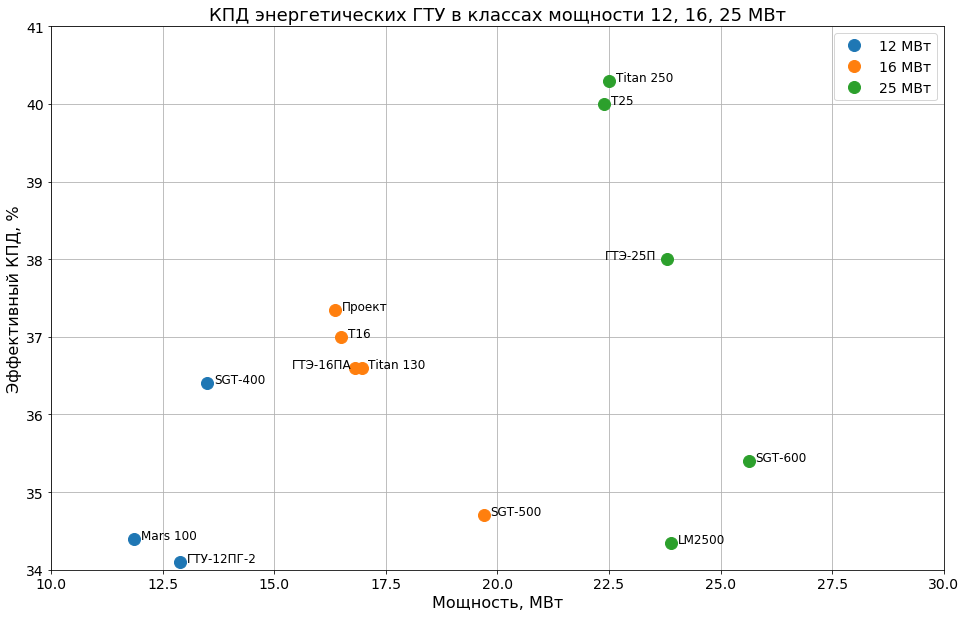

In [104]:
%matplotlib inline
plt.figure(figsize=(16, 10))

plt.plot(class12MW.N, class12MW.eta_e, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.eta_e[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.eta_e[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] + 0.15, class12MW.eta_e[2], class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.eta_e, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 1.4, class16MW.eta_e[0], class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.eta_e[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.eta_e[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] + 0.15, class16MW.eta_e[3], class16MW.Engine[3], fontsize=12)
plt.text(class16MW.N[4] + 0.15, class16MW.eta_e[4], class16MW.Engine[4], fontsize=12)

plt.plot(class25MW.N, class25MW.eta_e, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.eta_e[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.eta_e[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] + 0.15, class25MW.eta_e[2], class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.eta_e[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] + 0.15, class25MW.eta_e[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Эффективный КПД, %', fontsize=16)
plt.title('КПД энергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.ylim(34, 41)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots/analog_eff.png')

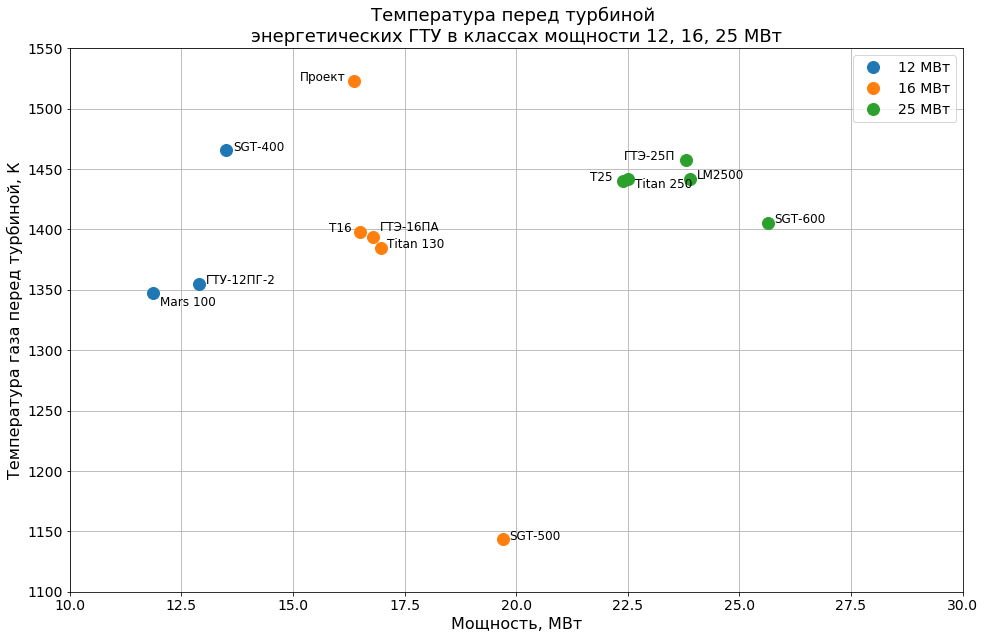

In [105]:
plt.figure(figsize=(16, 10))

plt.plot(class12MW.N, class12MW.T_gas, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.T_gas[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.T_gas[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] + 0.15, class12MW.T_gas[2] - 10, class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.T_gas, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] + 0.15, class16MW.T_gas[0] + 5, class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.T_gas[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.T_gas[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] - 0.7, class16MW.T_gas[3], class16MW.Engine[3], fontsize=12)
plt.text(class16MW.N[4] - 1.2, class16MW.T_gas[4], class16MW.Engine[4], fontsize=12)

plt.plot(class25MW.N, class25MW.T_gas, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.T_gas[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.T_gas[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] + 0.15, class25MW.T_gas[2] - 7, class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.T_gas[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] - 0.75, class25MW.T_gas[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Температура газа перед турбиной, К', fontsize=16)
plt.title('Температура перед турбиной \nэнергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.ylim(1100, 1550)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots/analog_T_gas.png')

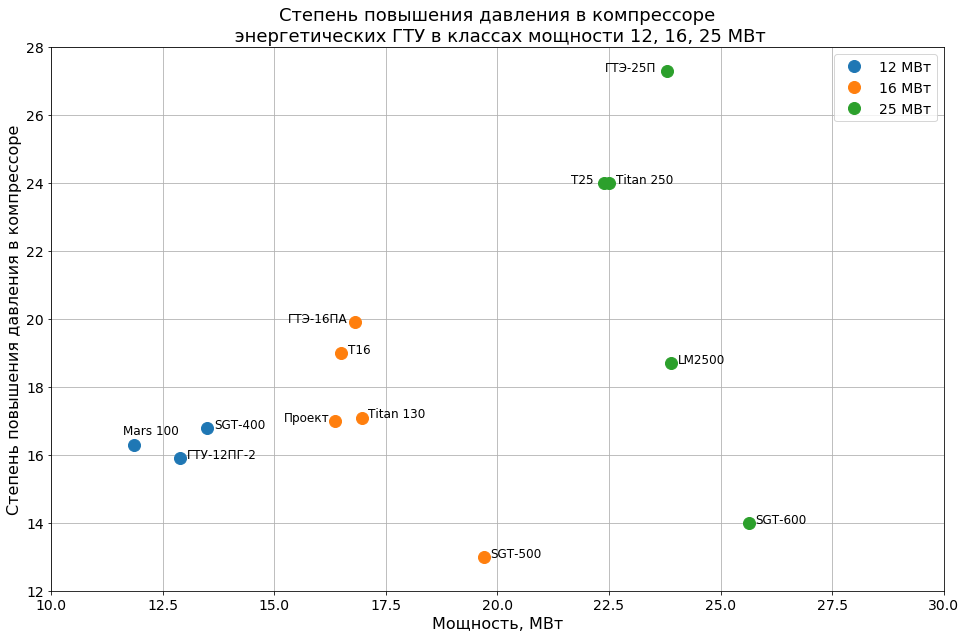

In [106]:
plt.figure(figsize=(16, 10))
plt.plot(class12MW.N, class12MW.pi_c, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.pi_c[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.pi_c[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] - 0.25, class12MW.pi_c[2] + 0.3, class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.pi_c, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 1.5, class16MW.pi_c[0], class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.pi_c[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.pi_c[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] + 0.15, class16MW.pi_c[3], class16MW.Engine[3], fontsize=12)
plt.text(class16MW.N[4] - 1.15, class16MW.pi_c[4], class16MW.Engine[4], fontsize=12)

plt.plot(class25MW.N, class25MW.pi_c, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.pi_c[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.pi_c[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] + 0.15, class25MW.pi_c[2], class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.pi_c[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] - 0.75, class25MW.pi_c[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Степень повышения давления в компрессоре', fontsize=16)
plt.title('Степень повышения давления в компрессоре\n энергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.ylim(12, 28)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots/analog_pi_c.png')

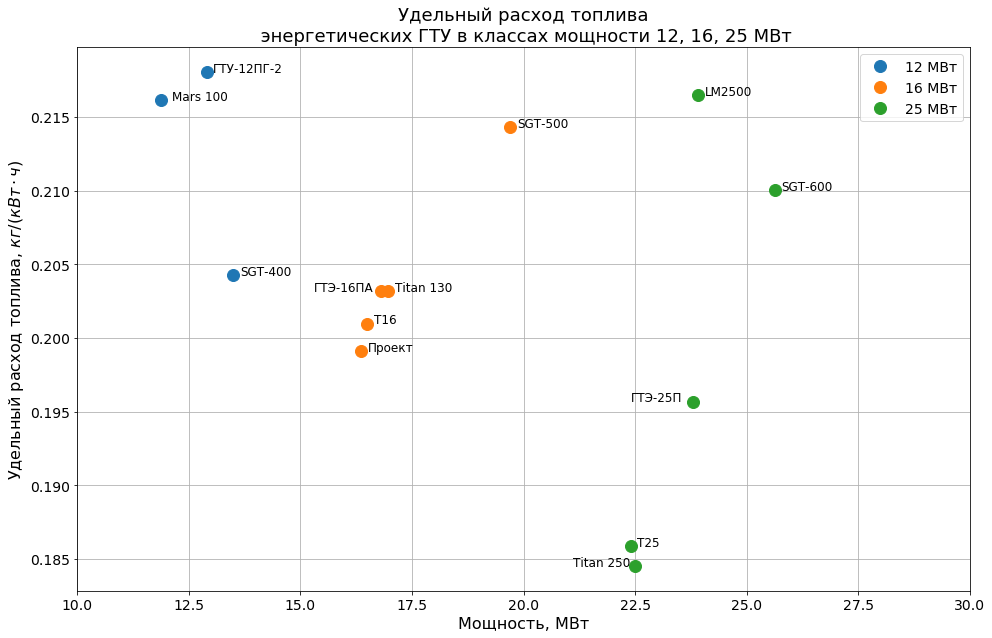

In [107]:
plt.figure(figsize=(16, 10))
plt.plot(class12MW.N, class12MW.C_e, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.15, class12MW.C_e[0], class12MW.Engine[0], fontsize=12)
plt.text(class12MW.N[1] + 0.15, class12MW.C_e[1], class12MW.Engine[1], fontsize=12)
plt.text(class12MW.N[2] + 0.25, class12MW.C_e[2], class12MW.Engine[2], fontsize=12)

plt.plot(class16MW.N, class16MW.C_e, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 1.5, class16MW.C_e[0], class16MW.Engine[0], fontsize=12)
plt.text(class16MW.N[1] + 0.15, class16MW.C_e[1], class16MW.Engine[1], fontsize=12)
plt.text(class16MW.N[2] + 0.15, class16MW.C_e[2], class16MW.Engine[2], fontsize=12)
plt.text(class16MW.N[3] + 0.15, class16MW.C_e[3], class16MW.Engine[3], fontsize=12)
plt.text(class16MW.N[4] + 0.15, class16MW.C_e[4], class16MW.Engine[4], fontsize=12)

plt.plot(class25MW.N, class25MW.C_e, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 1.4, class25MW.C_e[0], class25MW.Engine[0], fontsize=12)
plt.text(class25MW.N[1] + 0.15, class25MW.C_e[1], class25MW.Engine[1], fontsize=12)
plt.text(class25MW.N[2] - 1.4, class25MW.C_e[2], class25MW.Engine[2], fontsize=12)
plt.text(class25MW.N[3] + 0.15, class25MW.C_e[3], class25MW.Engine[3], fontsize=12)
plt.text(class25MW.N[4] + 0.15, class25MW.C_e[4], class25MW.Engine[4], fontsize=12)

plt.xlabel('Мощность, МВт', fontsize=16)
plt.ylabel('Удельный расход топлива, $кг / (кВт \cdot ч)$', fontsize=16)
plt.title('Удельный расход топлива\n энергетических ГТУ в классах мощности 12, 16, 25 МВт', fontsize=18)
plt.xlim(10, 30)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.savefig('plots/analog_c_e.png')

# Графики для чертежа

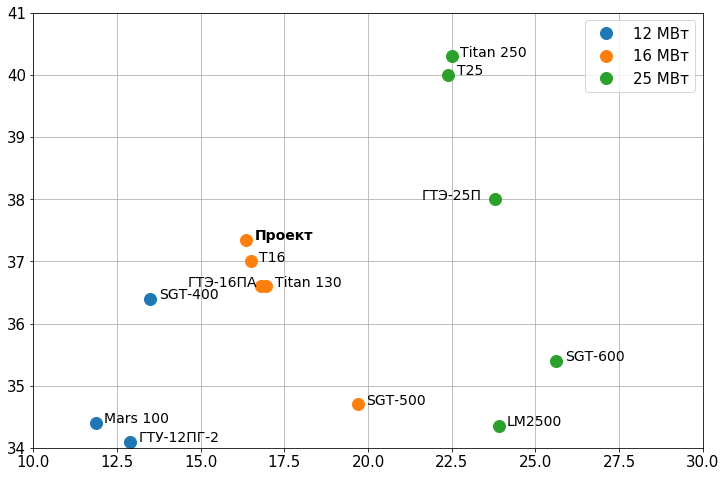

In [128]:
plt.figure(figsize=(12, 8))

plt.plot(class12MW.N, class12MW.eta_e, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.25, class12MW.eta_e[0], class12MW.Engine[0], fontsize=14)
plt.text(class12MW.N[1] + 0.25, class12MW.eta_e[1], class12MW.Engine[1], fontsize=14)
plt.text(class12MW.N[2] + 0.25, class12MW.eta_e[2], class12MW.Engine[2], fontsize=14)

plt.plot(class16MW.N, class16MW.eta_e, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 2.2, class16MW.eta_e[0], class16MW.Engine[0], fontsize=14)
plt.text(class16MW.N[1] + 0.25, class16MW.eta_e[1], class16MW.Engine[1], fontsize=14)
plt.text(class16MW.N[2] + 0.25, class16MW.eta_e[2], class16MW.Engine[2], fontsize=14)
plt.text(class16MW.N[3] + 0.25, class16MW.eta_e[3], class16MW.Engine[3], fontsize=14)
plt.text(class16MW.N[4] + 0.25, class16MW.eta_e[4], class16MW.Engine[4], fontsize=14, weight='bold')

plt.plot(class25MW.N, class25MW.eta_e, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 2.2, class25MW.eta_e[0], class25MW.Engine[0], fontsize=14)
plt.text(class25MW.N[1] + 0.25, class25MW.eta_e[1], class25MW.Engine[1], fontsize=14)
plt.text(class25MW.N[2] + 0.25, class25MW.eta_e[2], class25MW.Engine[2], fontsize=14)
plt.text(class25MW.N[3] + 0.25, class25MW.eta_e[3], class25MW.Engine[3], fontsize=14)
plt.text(class25MW.N[4] + 0.25, class25MW.eta_e[4], class25MW.Engine[4], fontsize=14)


plt.xlim(10, 30)
plt.ylim(34, 41)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig(os.path.join(config.draw_plots_dir, 'analog_eff.png'))

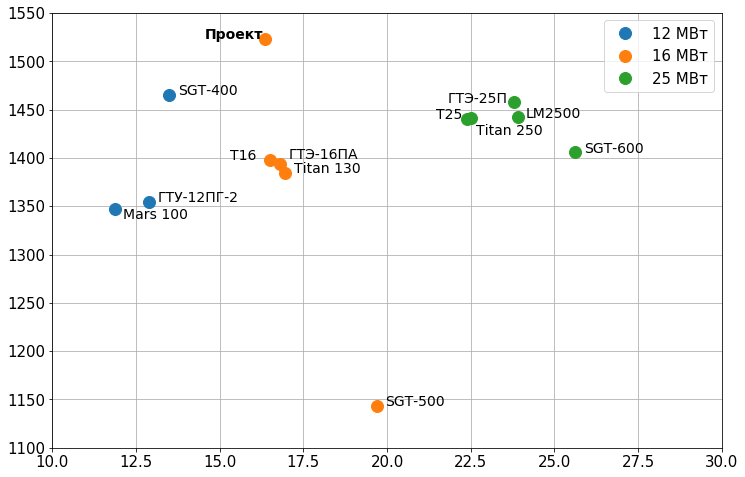

In [129]:
plt.figure(figsize=(12, 8))

plt.plot(class12MW.N, class12MW.T_gas, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.25, class12MW.T_gas[0], class12MW.Engine[0], fontsize=14)
plt.text(class12MW.N[1] + 0.25, class12MW.T_gas[1], class12MW.Engine[1], fontsize=14)
plt.text(class12MW.N[2] + 0.25, class12MW.T_gas[2] - 10, class12MW.Engine[2], fontsize=14)

plt.plot(class16MW.N, class16MW.T_gas, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] + 0.25, class16MW.T_gas[0] + 5, class16MW.Engine[0], fontsize=14)
plt.text(class16MW.N[1] + 0.25, class16MW.T_gas[1], class16MW.Engine[1], fontsize=14)
plt.text(class16MW.N[2] + 0.25, class16MW.T_gas[2], class16MW.Engine[2], fontsize=14)
plt.text(class16MW.N[3] - 1.2, class16MW.T_gas[3], class16MW.Engine[3], fontsize=14)
plt.text(class16MW.N[4] - 1.8, class16MW.T_gas[4], class16MW.Engine[4], fontsize=14, weight='bold')

plt.plot(class25MW.N, class25MW.T_gas, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 2, class25MW.T_gas[0], class25MW.Engine[0], fontsize=14)
plt.text(class25MW.N[1] + 0.25, class25MW.T_gas[1], class25MW.Engine[1], fontsize=14)
plt.text(class25MW.N[2] + 0.15, class25MW.T_gas[2] - 18, class25MW.Engine[2], fontsize=14)
plt.text(class25MW.N[3] + 0.25, class25MW.T_gas[3], class25MW.Engine[3], fontsize=14)
plt.text(class25MW.N[4] - 0.95, class25MW.T_gas[4], class25MW.Engine[4], fontsize=14)

plt.xlim(10, 30)
plt.ylim(1100, 1550)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig(os.path.join(config.draw_plots_dir, 'analog_T_gas.png'))

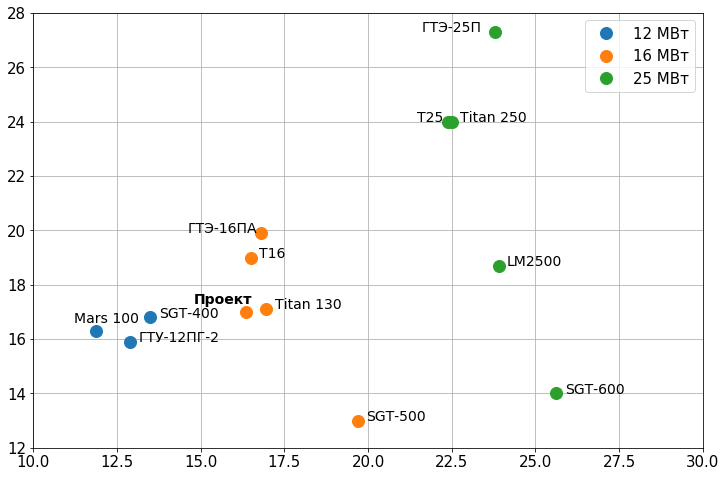

In [130]:
plt.figure(figsize=(12, 8))
plt.plot(class12MW.N, class12MW.pi_c, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.25, class12MW.pi_c[0], class12MW.Engine[0], fontsize=14)
plt.text(class12MW.N[1] + 0.25, class12MW.pi_c[1], class12MW.Engine[1], fontsize=14)
plt.text(class12MW.N[2] - 0.65, class12MW.pi_c[2] + 0.3, class12MW.Engine[2], fontsize=14)

plt.plot(class16MW.N, class16MW.pi_c, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 2.2, class16MW.pi_c[0], class16MW.Engine[0], fontsize=14)
plt.text(class16MW.N[1] + 0.25, class16MW.pi_c[1], class16MW.Engine[1], fontsize=14)
plt.text(class16MW.N[2] + 0.25, class16MW.pi_c[2], class16MW.Engine[2], fontsize=14)
plt.text(class16MW.N[3] + 0.25, class16MW.pi_c[3], class16MW.Engine[3], fontsize=14)
plt.text(class16MW.N[4] - 1.55, class16MW.pi_c[4] + 0.3, class16MW.Engine[4], fontsize=14, weight='bold')

plt.plot(class25MW.N, class25MW.pi_c, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 2.2, class25MW.pi_c[0], class25MW.Engine[0], fontsize=14)
plt.text(class25MW.N[1] + 0.25, class25MW.pi_c[1], class25MW.Engine[1], fontsize=14)
plt.text(class25MW.N[2] + 0.25, class25MW.pi_c[2], class25MW.Engine[2], fontsize=14)
plt.text(class25MW.N[3] + 0.25, class25MW.pi_c[3], class25MW.Engine[3], fontsize=14)
plt.text(class25MW.N[4] - 0.95, class25MW.pi_c[4], class25MW.Engine[4], fontsize=14)

plt.xlim(10, 30)
plt.ylim(12, 28)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig(os.path.join(config.draw_plots_dir, 'analog_pi_c.png'))

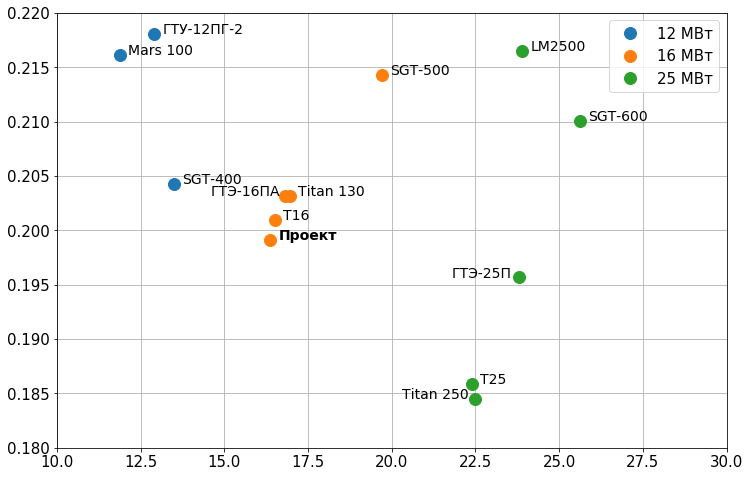

In [131]:
plt.figure(figsize=(12, 8))
plt.plot(class12MW.N, class12MW.C_e, linestyle='', marker='o', ms=12, label='12 МВт')
plt.text(class12MW.N[0] + 0.25, class12MW.C_e[0], class12MW.Engine[0], fontsize=14)
plt.text(class12MW.N[1] + 0.25, class12MW.C_e[1], class12MW.Engine[1], fontsize=14)
plt.text(class12MW.N[2] + 0.25, class12MW.C_e[2], class12MW.Engine[2], fontsize=14)

plt.plot(class16MW.N, class16MW.C_e, linestyle='', marker='o', ms=12, label='16 МВт')
plt.text(class16MW.N[0] - 2.2, class16MW.C_e[0], class16MW.Engine[0], fontsize=14)
plt.text(class16MW.N[1] + 0.25, class16MW.C_e[1], class16MW.Engine[1], fontsize=14)
plt.text(class16MW.N[2] + 0.25, class16MW.C_e[2], class16MW.Engine[2], fontsize=14)
plt.text(class16MW.N[3] + 0.25, class16MW.C_e[3], class16MW.Engine[3], fontsize=14)
plt.text(class16MW.N[4] + 0.25, class16MW.C_e[4], class16MW.Engine[4], fontsize=14, weight='bold')

plt.plot(class25MW.N, class25MW.C_e, linestyle='', marker='o', ms=12, label='25 МВт')
plt.text(class25MW.N[0] - 2, class25MW.C_e[0], class25MW.Engine[0], fontsize=14)
plt.text(class25MW.N[1] + 0.25, class25MW.C_e[1], class25MW.Engine[1], fontsize=14)
plt.text(class25MW.N[2] - 2.2, class25MW.C_e[2], class25MW.Engine[2], fontsize=14)
plt.text(class25MW.N[3] + 0.25, class25MW.C_e[3], class25MW.Engine[3], fontsize=14)
plt.text(class25MW.N[4] + 0.25, class25MW.C_e[4], class25MW.Engine[4], fontsize=14)

plt.xlim(10, 30)
plt.ylim(0.18, 0.22)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.savefig(os.path.join(config.draw_plots_dir, 'analog_c_e.png'))